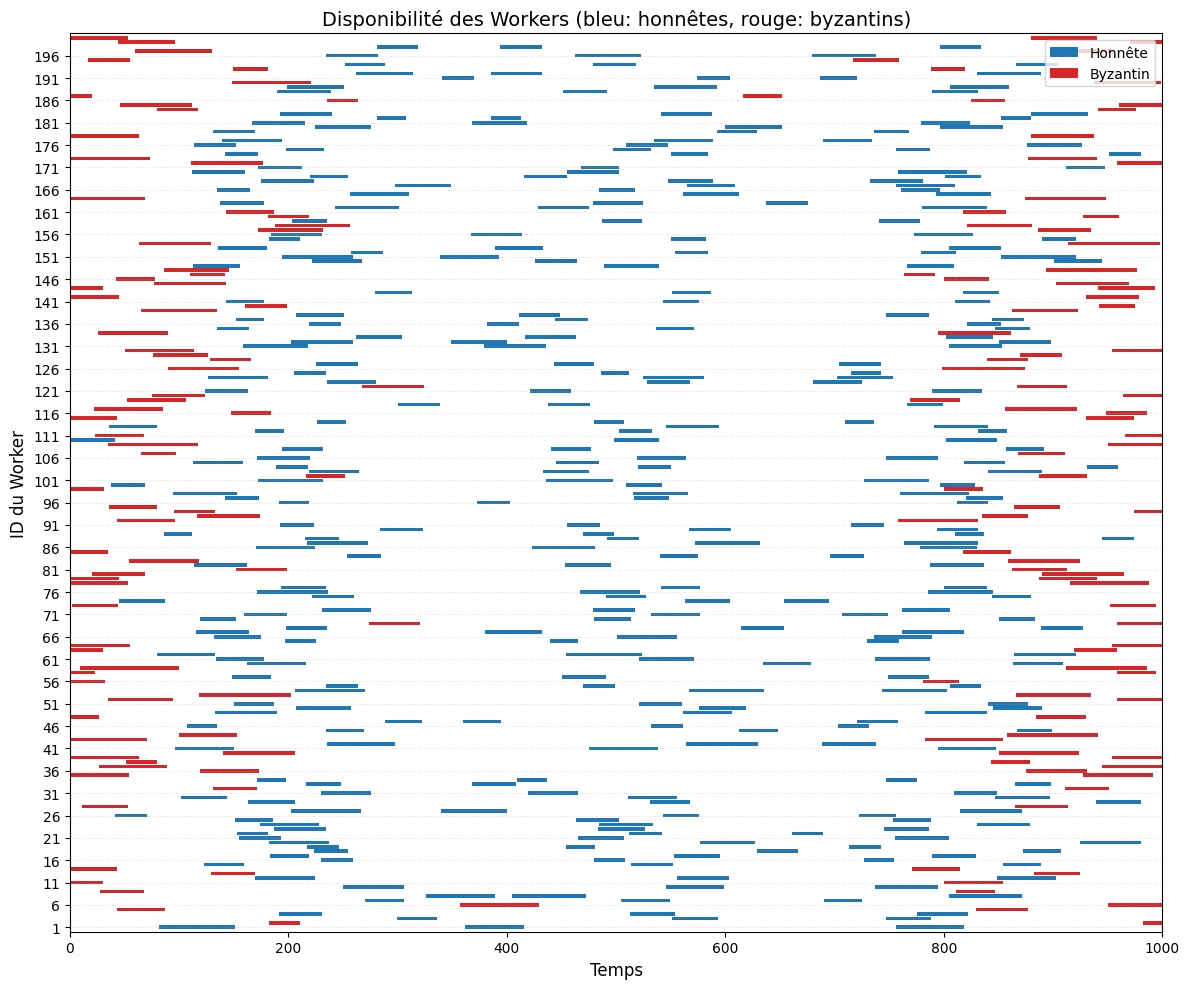

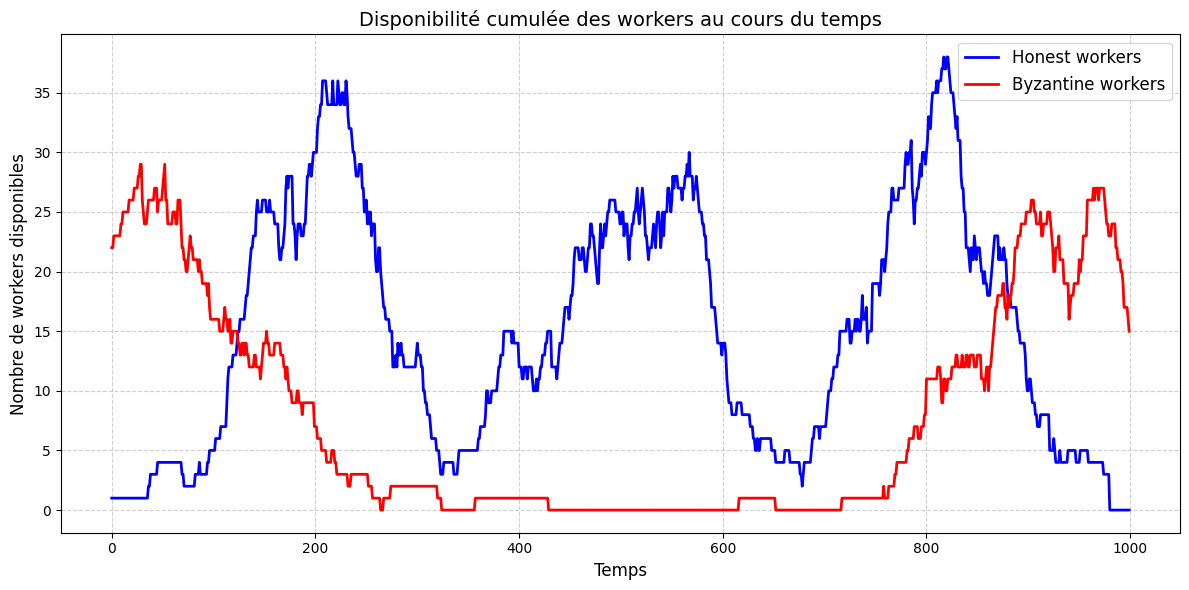

SafePoint initial — Acc: 11.00% | ValLoss: 2.3083
[t=7] Full batch 1 → Acc: 9.90%, Loss: 2.3038
[t=13] Full batch 2 → Acc: 9.90%, Loss: 2.3038


KeyboardInterrupt: 

In [ ]:
# === Standard libraries ===
import random
import math
import copy

# === Third-party libraries ===
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === PyTorch ===
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler

# === torchvision ===
from torchvision import datasets, transforms

# === Local or project-specific ===
import byzfl




# ------------------------------------------------------------------------------
# Fonctions utilitaires (inchangées)
def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for current in intervals[1:]:
        last = merged[-1]
        if current[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], current[1]))
        else:
            merged.append(current)
    return merged

def generate_gaussian_availability(total_time_steps, worker_id, num_workers,
                                   std_dev_ratio=0.065, min_processing_time=3,
                                   smoothing_window=10):
    peak_means = [0.2, 0.5, 0.8]
    std_dev = int(std_dev_ratio * total_time_steps)
    availability_periods = []
    for mean_ratio in peak_means:
        mean = int(mean_ratio * total_time_steps)
        start_time = int(np.random.normal(loc=mean, scale=std_dev))
        start_time = max(0, min(start_time, total_time_steps - min_processing_time*3))
        duration = random.randint(min_processing_time*3,
                                  min(min_processing_time*5, total_time_steps - start_time))
        end_time = start_time + duration
        availability_periods.append((start_time, end_time))
    merged = merge_intervals(availability_periods)
    smoothed = []
    for s, e in merged:
        s2 = max(0, s - smoothing_window)
        e2 = min(total_time_steps, e + smoothing_window)
        smoothed.append((s2, e2))
    return merge_intervals(smoothed)

def generate_gaussian_byzantine_availability(
    total_time_steps, worker_id, num_workers,
    std_dev_ratio=0.08, min_processing_time=3,
    smoothing_window=10
):
    off_peak_means = [0.08, 0.9]
    std_dev = int(std_dev_ratio * total_time_steps)
    availability_periods = []
    for mean_ratio in off_peak_means:
        mean = int(mean_ratio * total_time_steps)
        start = int(np.random.normal(loc=mean, scale=std_dev))
        start = max(0, min(start, total_time_steps - min_processing_time*4))
        duration = random.randint(
            min_processing_time*4,
            min(min_processing_time*8, total_time_steps - start)
        )
        availability_periods.append((start, start + duration))
    merged = merge_intervals(availability_periods)
    smoothed = []
    for s, e in merged:
        s2 = max(0, s - smoothing_window)
        e2 = min(total_time_steps, e + smoothing_window)
        smoothed.append((s2, e2))
    return merge_intervals(smoothed)

# ------------------------------------------------------------------------------
# Modèle LeNet-like
class LeNetLike(nn.Module):
    def __init__(self):
        super(LeNetLike, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------------------------------------------------------------------
# Gestionnaire de batch
class BatchManager:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = list(range(len(dataset)))
        random.shuffle(self.indices)
        self.sampler = SubsetRandomSampler(self.indices)
        self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
    def get_next_batch(self):
        try:
            return next(self.loader)
        except StopIteration:
            random.shuffle(self.indices)
            self.sampler = SubsetRandomSampler(self.indices)
            self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
            return next(self.loader)

# ------------------------------------------------------------------------------
# Worker honnête
class Worker:
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        self.is_byzantine = False
        self.device = device
        self.worker_id = worker_id
        self.availability_periods = availability_periods
        self.processing_time = processing_time
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.finish_time = None
        self.current_batch_info = None
        self._pending = None

    def is_available(self, current_time):
        for start, end in self.availability_periods:
            if start <= current_time < end and (self.finish_time is None or current_time >= self.finish_time):
                return (current_time + self.processing_time) <= end
        return False

    def start_computation(self, current_time, batch_info, data, targets):
        # on prépare juste la tâche, sans lancer le calcul immédiat
        if self.current_batch_info != batch_info:
            self.current_batch_info = batch_info
            self.finish_time = current_time + self.processing_time
            self._pending = (data, targets)
        return None

    def has_finished(self, current_time):
        # dès que le délai arrive, on réalise le calcul
        if self.finish_time == current_time and self._pending is not None:
            data, targets = self._pending
            self._pending = None
            grads, bi = self.compute_gradient(data, targets)
            return True, grads, bi
        return False, None, None

    def compute_gradient(self, data, targets):
        data, targets = data.to(self.device), targets.to(self.device)
        self.model.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        loss.backward()
        gradients = {name: param.grad.detach().clone() for name, param in self.model.named_parameters()}
        return gradients, self.current_batch_info

    def update_model(self, model_state_dict):
        self.model.load_state_dict(model_state_dict)



class ByzantineWorker(Worker):
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        super().__init__(model, device, worker_id, availability_periods, processing_time)
        self.is_byzantine = True

    
    #     # 1) on calcule d'abord le gradient honnête
    #     honest_grads, batch_info = super().compute_gradient(data, targets)

    #     if random.random() < 0.5:
    #         # 50% du temps : gradient constant magnitude aléatoire
    #         mag = random.uniform(0.5e6, 9e6)
    #         corrupted = {
    #             name: torch.full_like(param, mag)
    #             for name, param in self.model.named_parameters()
    #         }
    #     else:
    #         # 50% du temps : on renvoie exactement l'opposé
    #         corrupted = {
    #             name: -grad
    #             for name, grad in honest_grads.items()
    #         }

    #     return corrupted, batch_info
    def compute_gradient(self, data, targets):
        honest_grads, batch_info = super().compute_gradient(data, targets)

        if random.random() < 0.5:
            # 50% : gradient constant fort
            mag = random.uniform(0.5e6, 9e6)
            corrupted = {
                name: torch.full_like(param, mag)
                for name, param in self.model.named_parameters()
            }
        else:
            # 50% : rotation agressive dans l'espace des paramètres
            # 1) concatène tous les grads
            flats, shapes = [], []
            for name, grad in honest_grads.items():
                flats.append(grad.view(-1))
                shapes.append((name, grad.shape))
            g = torch.cat(flats)

            # 2) génère u orthogonal à g
            r = torch.randn_like(g)
            proj = (torch.dot(g, r) / torch.dot(g, g)) * g if torch.dot(g, g)>0 else torch.zeros_like(g)
            u = r - proj
            # normalise u à la norme de g
            if u.norm()>0:
                u = u * (g.norm() / u.norm())

            # 3) choisis un angle θ ∈ [90°,270°]
            theta = random.uniform(math.pi/2, 3*math.pi/2)
            corrupt_vec =  math.cos(theta) * g + math.sin(theta) * u

            # 4) re-split en dict
            corrupted = {}
            idx = 0
            for name, shape in shapes:
                numel = int(torch.tensor(shape).prod().item())
                corrupted[name] = corrupt_vec[idx:idx+numel].view(shape)
                idx += numel

        return corrupted, batch_info

# ------------------------------------------------------------------------------
# Serveur sans logique de vote
class Server:
    def __init__(self, dataset, batch_size=64, mini_batch_size=16, lr=0.005, verbose=False,
                 aggregation_strategy='trimmed_mean', f=0, preagg=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = LeNetLike().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_manager = BatchManager(dataset, batch_size)
        self.mini_batch_size = mini_batch_size
        self.current_batch_id = 0
        self.received_gradients = {}
        self.verbose = verbose
        self.aggregation_strategy = aggregation_strategy
        self.f = f
        self.preagg = preagg
        self.total_raw_compute_time = 0
        self.total_useful_compute_time = 0
        self.total_waste_compute_time = 0
        self.current_full_batch_compute_time = 0
        self.criterion = nn.CrossEntropyLoss()

    def get_new_complete_batch(self, current_time):
        data, targets = self.batch_manager.get_next_batch()
        self.current_batch_id += 1
        self.current_full_batch_compute_time = 0
        num = data.size(0)
        minibatches = [
            (data[i:i+self.mini_batch_size], targets[i:i+self.mini_batch_size])
            for i in range(0, num, self.mini_batch_size)
        ]
        self.current_mini_batches = {i: minibatches[i] for i in range(len(minibatches))}
        self.received_gradients = {}
        if self.verbose:
            print(f"[Temps {current_time}] Full batch {self.current_batch_id} préparé.")

    def register_gradient(self, gradients, batch_info, worker_id, current_time, worker_processing_time, is_byzantine=False):
        bid, mid = batch_info
        if bid != self.current_batch_id or mid in self.received_gradients:
            return
        self.total_raw_compute_time += worker_processing_time
        self.current_full_batch_compute_time += worker_processing_time
        self.received_gradients[mid] = gradients
        if self.verbose:
            tag = " (Byzantin)" if is_byzantine else ""
            print(f"[Temps {current_time}] Gradient mini-batch {mid} de worker {worker_id}{tag}.")

    def aggregate_and_update(self):
        if len(self.received_gradients) != len(self.current_mini_batches):
            if self.verbose:
                print("⚠️ Pas assez de gradients reçus.")
            return False

        pre = None
        if self.preagg == "NNM":
            pre = byzfl.NNM(f=self.f)
        elif self.preagg == "Bucketing":
            pre = byzfl.Bucketing(s=1)
        elif self.preagg == "ARC":
            pre = byzfl.ARC(f=self.f)

        aggs = {}
        for name, param in self.model.named_parameters():
            grads = [self.received_gradients[i][name] for i in sorted(self.current_mini_batches)]
            G = torch.stack(grads).view(len(grads), -1)
            if pre:
                G = pre(G)
            if self.aggregation_strategy == "trimmed_mean":
                agg_flat = byzfl.TrMean(f=max(self.f, (len(grads)//2)-1))(G)
            else:
                agg_flat = byzfl.Average()(G)
            aggs[name] = agg_flat.view(param.size())

        self.optimizer.zero_grad()
        for name, param in self.model.named_parameters():
            param.grad = aggs[name]
        self.optimizer.step()
        if self.verbose:
            print(f"Modèle mis à jour (batch {self.current_batch_id}).")
        return True

    def evaluate_acc(self, eval_loader):
        self.model.eval()
        correct = total = 0
        with torch.no_grad():
            for d, t in eval_loader:
                d, t = d.to(self.device), t.to(self.device)
                out = self.model(d)
                pred = out.argmax(dim=1)
                total += t.size(0)
                correct += (pred == t).sum().item()
        return 100 * correct / total
    
    def evaluate_loss(self, eval_loader):
        """
        Compute the average validation loss over eval_loader.
        """
        self.model.eval()
        total_loss = 0.0
        total_samples = 0

        with torch.no_grad():
            for x, t in eval_loader:
                x, t = x.to(self.device), t.to(self.device)
                out = self.model(x)
                loss = self.criterion(out, t)
                batch_size = x.size(0)
                total_loss += loss.item() * batch_size
                total_samples += batch_size
        self.model.train()
        return total_loss / total_samples

    def report_compute_metrics(self):
        total = self.total_raw_compute_time
        useful = self.total_useful_compute_time
        waste = self.total_waste_compute_time
        rate = 100 * waste / total if total else 0
        print("\n📊 Rapport de temps de calcul :")
        print(f"- Temps brut total : {total}")
        print(f"- Temps utile      : {useful}")
        print(f"- Temps gaspillé   : {waste}")
        print(f"- Taux gaspillage  : {rate:.2f}%")

    def advance_decision(self, p1, p2, p3, sp, delta=2):
        if p1 == p2 == p3:
            return "rollback"
        conds = [
            p1>sp and p2>p1 and p3>sp+delta,
            p1>sp and p2<=p1 and p3>p1,
            p1<=sp and p2>sp and p3>p2,
            p1<=sp and p2>p1 and p2>sp and p3<p2 and p3>sp,
            p1<=sp and p2<=p1 and p3>sp
        ]
        return "accept" if any(conds) else "rollback"
    

    def linear_trend_by_batch(self, batch_idxs, accs, safe_acc, slope_thresh=0.5):
        """
        batch_idxs : liste des numéros de full-batch (ex: [71,72,…,80])
        accs       : liste des accuracies correspondantes
        safe_acc   : accuracy du dernier safe-point
        slope_thresh : seuil de pente (en % d'acc par batch)
        """
        # transformer les batch_idxs en 0,1,2,...
        x = np.arange(len(batch_idxs))
        y = np.array(accs)
        slope, _ = np.polyfit(x, y, 1)
        if slope > slope_thresh and y[-1] > safe_acc:
            return "accept"
        else:
            return "rollback"
        
    

# ------------------------------------------------------------------------------
def create_workers(num_worker, byzantine_indices_cycle, steps_per_cycle, server):
    workers = []
    for i in range(1, num_worker+1):
        pt = random.randint(2,10)
        if i in byzantine_indices_cycle:
            av = generate_gaussian_byzantine_availability(steps_per_cycle, i, num_worker, min_processing_time=pt)
            workers.append(ByzantineWorker(server.model, server.device, i, av, pt))
        else:
            av = generate_gaussian_availability(steps_per_cycle, i, num_worker, min_processing_time=pt)
            workers.append(Worker(server.model, server.device, i, av, pt))
    return workers

# ------------------------------------------------------------------------------
class SafePointSimulator:
    def __init__(self, server, workers, val_loader, test_loader, total_time_steps=1000, group_size=3):
        self.server = server
        self.workers = workers
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.total_time_steps = total_time_steps
        self.group_size = group_size
        self.global_time = 0
        self.in_progress_workers = []
        self.server.get_new_complete_batch(self.global_time)

        self.plot_worker_availability()

    def plot_worker_availability(self):
        """
        Affiche, pour chaque instant de temps, le nombre total de workers honnêtes (bleu)
        et Byzantins (rouge) disponibles.
        """

        num_workers = len(self.workers)
        fig_height = max(6, min(0.05 * num_workers, 20))
        fig, ax = plt.subplots(figsize=(12, fig_height))
        for worker in self.workers:
            color = "tab:red" if isinstance(worker, ByzantineWorker) else "tab:blue"
            for (start, end) in worker.availability_periods:
                ax.broken_barh([(start, end - start)], (worker.worker_id - 0.4, 0.8), facecolors=color)
        ax.set_xlabel("Temps", fontsize=12)
        ax.set_ylabel("ID du Worker", fontsize=12)
        ax.set_title("Disponibilité des Workers (bleu: honnêtes, rouge: byzantins)", fontsize=14)
        ax.set_xlim(0, self.total_time_steps)
        max_worker_id = max(worker.worker_id for worker in self.workers)
        ax.set_ylim(0, max_worker_id + 1)
        step = max(1, num_workers // 40)
        ax.set_yticks(list(range(1, max_worker_id + 1, step)))
        ax.grid(True, axis='y', linestyle='--', alpha=0.2)
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='tab:blue', label='Honnête'),
            Patch(facecolor='tab:red', label='Byzantin')
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        plt.tight_layout()
        plt.show()


        # Initialiser deux tableaux pour compter séparément
        avail_honest = [0] * self.total_time_steps
        avail_byz   = [0] * self.total_time_steps

        for worker in self.workers:
            target = avail_byz if worker.is_byzantine else avail_honest
            for start, end in worker.availability_periods:
                for t in range(start, min(end, self.total_time_steps)):
                    target[t] += 1

        times = range(self.total_time_steps)
        plt.figure(figsize=(12, 6))
        plt.plot(times, avail_honest, label="Honest workers", color="blue", linewidth=2)
        plt.plot(times, avail_byz,   label="Byzantine workers", color="red",  linewidth=2)
        plt.xlabel("Temps", fontsize=12)
        plt.ylabel("Nombre de workers disponibles", fontsize=12)
        plt.title("Disponibilité cumulée des workers au cours du temps", fontsize=14)
        plt.legend(loc="upper right", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


    def run(self, verbose=False, eval_interval=10):
        # 0) initialisation du safe-point (accuracy + loss)
        # 0) initialisation du safe-point (accuracy + loss)
        safe_model = copy.deepcopy(self.server.model.state_dict())
        safe_opt   = copy.deepcopy(self.server.optimizer.state_dict())
        # accuracy
        safe_acc   = self.server.evaluate_acc(self.val_loader)
        # loss
        safe_loss = self.server.evaluate_loss(self.val_loader)
        
        print(f"SafePoint initial — Acc: {safe_acc:.2f}% | ValLoss: {safe_loss:.4f}")

        # historiques
        global_valid_accs   = [safe_acc]
        global_valid_losses = [safe_loss]
        group_updates       = []
        group_losses        = []
        group_durations     = []
        count = idx = 0

        time_points, acc_over_time = [], []
        k = 1

        while self.global_time < self.total_time_steps:
            # 1) récupération des workers terminés
            for w in list(self.in_progress_workers):
                fini, grads, bi = w.has_finished(self.global_time)
                if not fini:
                    continue
                self.server.register_gradient(
                    grads, bi, w.worker_id, self.global_time,
                    w.processing_time, w.is_byzantine
                )
                self.in_progress_workers.remove(w)
                w.current_batch_info = None

            # 2) agrégation et mise à jour
            if len(self.server.received_gradients) == len(self.server.current_mini_batches):
                if self.server.aggregate_and_update():
                    # évaluation accuracy + loss
                    acc = self.server.evaluate_acc(self.val_loader)
                    self.server.model.eval()
                    val_loss = self.server.evaluate_loss(self.val_loader)

                    print(f"[t={self.global_time}] Full batch {self.server.current_batch_id} → Acc: {acc:.2f}%, Loss: {val_loss:.4f}")

                    # collecte
                    group_updates.append(acc)
                    group_losses.append(val_loss)
                    group_durations.append(self.server.current_full_batch_compute_time)
                    count += 1

                    self.server.get_new_complete_batch(self.global_time)
                    self.in_progress_workers.clear()

                    # décision
                    if count == self.group_size:
                        # 3a) pente linéaire de l'accuracy locale + gain absolu
                        eps_acc = 1e-5
                        x_acc = np.arange(len(group_updates))
                        slope_acc, _ = np.polyfit(x_acc, np.array(group_updates), 1)
                        print(slope_acc)
                        slope_acc = slope_acc if abs(slope_acc) > eps_acc else 0.0
                        delta_acc = group_updates[-1] - safe_acc
                        
                        print(slope_acc)
                        ok_acc = (slope_acc > 0) and (delta_acc > 0)
                        # 3b) pente linéaire de -loss locale + gain absolu
                        eps_loss = 1e-5
                        x_loss = np.arange(len(group_losses))
                        slope_loss, _ = np.polyfit(x_loss, -np.array(group_losses), 1)
                        print(slope_loss)
                        slope_loss = slope_loss if abs(slope_loss) > eps_loss else 0.0
                        delta_loss = safe_loss - group_losses[-1]
                        print(slope_loss)
                        ok_loss = (slope_loss > 0) and (delta_loss > 0)

                        # 3c) décision combinée : on exige progression sur les deux
                        accept = ok_acc and ok_loss
                        total_t = sum(group_durations)
                        if accept:
                            # ACCEPT : mise à jour du safe-point
                            safe_model = copy.deepcopy(self.server.model.state_dict())
                            safe_opt   = copy.deepcopy(self.server.optimizer.state_dict())
                            safe_acc   = group_updates[-1]
                            safe_loss  = group_losses[-1]
                            global_valid_accs.append(safe_acc)
                            global_valid_losses.append(safe_loss)
                            self.server.total_useful_compute_time += total_t
                            print(f"ACCEPT — Acc {safe_acc:.2f}%, Loss {safe_loss:.4f}")
                        else:
                            # ROLLBACK : restauration
                            self.server.model.load_state_dict(safe_model)
                            self.server.optimizer.load_state_dict(safe_opt)
                            self.server.total_waste_compute_time += total_t
                            print(f"ROLLBACK — Acc {safe_acc:.2f}%, Loss {safe_loss:.4f}")

                        # remise à zéro de la fenêtre de la fenêtre
                        group_updates.clear()
                        group_losses.clear()
                        group_durations.clear()
                        count = 0
                        idx += 1

            # 3) assignation des nouveaux tasks
            avail = [w for w in self.workers if w.is_available(self.global_time) and w not in self.in_progress_workers]
            for mi in sorted(self.server.current_mini_batches):
                if mi in self.server.received_gradients:
                    continue
                curr = len(self.server.received_gradients.get(mi, []))
                while curr < k and avail:
                    w = avail.pop(0)
                    w.update_model(copy.deepcopy(self.server.model.state_dict()))
                    data, tgt = self.server.current_mini_batches[mi]
                    w.start_computation(self.global_time, (self.server.current_batch_id, mi), data, tgt)
                    self.in_progress_workers.append(w)
                    curr += 1

            # 4) évaluation périodique sur test set
            if self.global_time % eval_interval == 0:
                at = self.server.evaluate_acc(self.test_loader)
                acc_over_time.append(at)
                time_points.append(self.global_time)

            self.global_time += 1

        # fin : restaurer 
        self.server.model.load_state_dict(safe_model)
        self.server.optimizer.load_state_dict(safe_opt)
        final_acc = self.server.evaluate_acc(self.test_loader)
        print(f"Final accuracy cycle: {final_acc:.2f}%")
        # plot
        plt.figure(figsize=(10,5))
        plt.plot(time_points, acc_over_time, linewidth=2)
        plt.title("Évolution accuracy")
        plt.xlabel("Time")
        plt.ylabel("Accuracy (%)")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        return time_points, acc_over_time, final_acc


# ----------------------------------------------------------------------------
def run_experiment(num_cycles=1, num_runs=1, steps_per_cycle=1000,
                   byzantine_ratio=0.0, aggregation_strategy='trimmed_mean', preagg=None):
    trajectories = {}
    num_worker = 200
    # data loaders MNIST
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    full_train = datasets.MNIST('./data', train=True, download=True, transform=trans)
    test_ds    = datasets.MNIST('./data', train=False, download=True, transform=trans)
    n_total = len(full_train)
    n_val   = int(0.20 * n_total)
    perm = torch.randperm(n_total)
    val_indices   = perm[:n_val].tolist()
    train_indices = perm[n_val:].tolist()
    train_loader = DataLoader(full_train, batch_size=640, sampler=SubsetRandomSampler(train_indices))
    val_loader   = DataLoader(full_train, batch_size=200, sampler=SubsetRandomSampler(val_indices))
    test_loader  = DataLoader(test_ds, batch_size=120, shuffle=False)

    for ratio in [0.3,0.4]:
        server = Server(train_loader.dataset,
                        batch_size=640,
                        mini_batch_size=64,
                        verbose=False,
                        aggregation_strategy=aggregation_strategy,
                        preagg=preagg)
        byz = set(random.sample(range(1, num_worker+1), int(num_worker * ratio)))
        workers = create_workers(num_worker, byz, steps_per_cycle, server)
        sim = SafePointSimulator(server, workers, val_loader, test_loader,
                                 total_time_steps=steps_per_cycle, group_size=10)
        tps, accs, final = sim.run(verbose=False, eval_interval=10)
        trajectories[ratio] = (tps, accs)
        server.report_compute_metrics()
    return trajectories

# ----------------------------------------------------------------------------
if __name__ == "__main__":
    steps_per_cycle = 1000
    trajectories = run_experiment(num_cycles=1,
                                  num_runs=1,
                                  steps_per_cycle=steps_per_cycle,
                                  aggregation_strategy='average',
                                  preagg=None)

    plt.figure(figsize=(10, 6))
    for ratio, (time_points, acc_over_time) in trajectories.items():
        plt.plot(time_points,
                 acc_over_time,
                 linewidth=2,
                 markersize=5,
                 label=f"{int(ratio*100)}% Byzantins")
    plt.xlabel("Temps", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.title("Évolution de l'accuracy au cours du temps", fontsize=16)
    plt.legend(title="Taux de Byzantins", fontsize=12, title_fontsize=13)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


faible contre les attaques qui durant le pics time même 10% de byzantins suffisent a biaser le modèle

fort quand les byzantins heures creuses